# Introduction

## Background (Same as Week 7 Workshop)

Today, 21 December 2021, we hold a portfolio consisting of physical assets and European options. The specification of each component is as follows:

1. A short position on 1,000 units of the ASSD 200
2. A long position on 2,500 units of the S\&P 500 (*Note: prices of the S\&P 500 provided in the data set are in US dollars*)
3. A long position on US\$ 4 million
4. A long position on 10,000 units of a European call option on a share of the ASSD 200 with a strike price of \$6,400 per unit and an expiry date of 26 November 2022
5. A long position on 20,000 units of a European put option on a share of the S\&P 500 with a strike price of \$ 2,980 per unit and an expiry date of 23 December 2022

We assume that the risk-free interest rates with maturity 26 November 2022 and 23 December 2022 are 3\% and 3.5\%, respectively. For purposes of option pricing, assume that the (annual) volatility of the ASSD 200 and S\&P 500 prices are 20\% and 25\%, respectively. 

## Tasks

Given the time series of financial data in `WorkshopWeek7Data.csv`, perform the following analysis:

1. **(Completed in Week 7 Workshop)** Determine the per-unit price, delta, and gamma of the European options in the portfolio. What is the resulting position value?
2. **(Completed in Week 7 Workshop)** Determine the marked-to-market value of the entire portfolio at the valuation date (21 December 2021).
3. Calculate the one-day 95\% VaR using historical simulation for each component and the entire portfolio.
4. Calculate the one-day 95\% VaR using weighted historical simulation for each component and the entire portfolio using $\lambda = 0.98$.

## Remarks

1. In this analysis, we shall use the log-returns of the risk factors instead of the percentage return.
2. While the historical time series of S&P 500 prices are denominated in US dollars, assume that the given strike price is in Australian dollars. As such, you may first convert the given S&P 500 prices to Australian dollars using the given time series of USD/AUD exchange rates and use the converted prices for the rest of the analysis. **How would the analysis differ if we do not convert the S&P500 prices and use both the US dollar price and the exchange rate as risk factors?**

# Preparation

## Utilities: European Option Pricing Functions

We load the required libraries and recall the functions we have written to price European options and to calculate their delta and gamma under the Black-Scholes-Merton model.

In [1]:
# Required libraries
import numpy as np
import scipy as sp
import scipy.stats
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from datetime import timedelta
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

In [2]:
# Pricing function for European calls and puts
def BSprice(spot_price, strike_price, time_to_maturity, risk_free_rate, dividend_yield, volatility, option_type):
    
    # Use mathematical notation for function inputs
    s = spot_price
    K = strike_price
    tau = time_to_maturity # (T-t) in notes
    r = risk_free_rate
    q = dividend_yield
    sigma = volatility
    
    # Calculate d1 and d2
    d1 = (np.log(s / K) + (r - q + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    
    # Calculate option prices
    if option_type == 'call':
        price = (np.exp(-q * tau) * s * sp.stats.norm.cdf(d1, 0.0, 1.0) \
                 - np.exp(-r * tau) * K * sp.stats.norm.cdf(d2, 0.0, 1.0))
        
    if option_type == 'put':
        price = (np.exp(-r * tau) * K * sp.stats.norm.cdf(-d2, 0.0, 1.0) \
                 - np.exp(-q * tau) * s * sp.stats.norm.cdf(-d1, 0.0, 1.0))
        
    return price

In [3]:
# Function to calculate option delta under the Black-Scholes-Merton model
def BSdelta(spot_price, strike_price, time_to_maturity, risk_free_rate, dividend_yield, volatility, option_type):
    
    # Use mathematical notation for function inputs
    s = spot_price
    K = strike_price
    tau = time_to_maturity # (T-t) in notes
    r = risk_free_rate
    q = dividend_yield
    sigma = volatility
    
    # Calculate d1 and d2
    d1 = (np.log(s / K) + (r - q + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    
    # Calculate option delta
    if option_type == 'call':
        value = sp.stats.norm.cdf(d1, 0.0, 1.0)
    
    if option_type == 'put':
        value = sp.stats.norm.cdf(d1, 0.0, 1.0) - 1
    
    return value    

In [4]:
# Function to calculate option gamma under the Black-Scholes-Merton model
def BSgamma(spot_price, strike_price, time_to_maturity, risk_free_rate, dividend_yield, volatility):
    
    # Use mathematical notation for function inputs
    s = spot_price
    K = strike_price
    tau = time_to_maturity # (T-t) in notes
    r = risk_free_rate
    q = dividend_yield
    sigma = volatility
    
    # Compute option gamma (same for calls and puts)
    d1 = (np.log(s / K) + (r - q + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    value = sp.stats.norm.pdf(d1, 0.0, 1.0) / (s * sigma * np.sqrt(tau))
    
    return value

## Data Pre-processing

We load the given historical data in `WorkshopWeek7Data.csv`, express the exchange rates as XX AUD per USD, and compute the Australian dollar price of the S\&P 500.

In [25]:
# Load data
fin_data = pd.read_csv('C:/Users/leeha/exercise.csv',index_col=0)
fin_data_idx = pd.read_csv('C:/Users/leeha/exercise.csv')
fin_data.head()

,ASSD,BARC,FTSE 100
date,,,
2015-06-09,24.51,320.0,2483.4
2015-06-10,24.75,316.0,2431.9
2015-06-11,26.65,317.0,2403.7
2015-06-12,26.65,329.0,2415.6
2015-06-13,26.65,327.0,2387.9


In [9]:
# Extract market data on the valuation date
fin_data_today = fin_data.loc['2019-05-08']
fin_data_today

ASSD         177.5
BARC        1618.0
FTSE 100    5224.1
Name: 2019-05-08, dtype: float64

In [30]:
fin_data_idx['date'].index(3)

TypeError: 'RangeIndex' object is not callable

In [12]:
# Compute the pct-returns of all market variables
fin_data_pctret = fin_data.pct_change().tail(-1)
fin_data_pctret_cov = fin_data_pctret.cov()
fin_data_pctret_cov.head()

,ASSD,BARC,FTSE 100
ASSD,0.000363,0.000062,0.000008
BARC,0.000062,0.000262,0.000001
FTSE 100,0.000008,0.000001,0.000062


# Mark-to-Market Valuation

## European Options

We encode all relevant information for the pricing of the European options in the portfolio, we also need to compute: 

1. The time to maturity in years (for simplicity, also assume 252 trading days when converting the time difference in days to years, although there is no reason there shouldn't be a different assumption for this conversion)
2. ~~The annual volatility of the underlying price processes (i.e. the annualized standard deviation of the log-returns) from the given data.~~ (It can be verified that using the volatility implied by the historical time series of prices will lead to very small option prices).

In [18]:
# Given option parameters
strike_ASSD = 175
strike_BARC = 1650
strike_FTSE = 5225
r_ASSD = 0.08
r_BARC = 0.08
r_FTSE = 0.08
N_op_ASSD = 10
N_op_BARC = 50
N_op_FTSE = 20
div_ASSD=0.02
div_BARC=0.025
div_FTSE=0.015
mat=0.25

 # Compute the annual volatilities in the underlying asset prices
vol_ASSD = np.sqrt(fin_data_pctret_cov.loc['ASSD', 'ASSD'] * 250)
vol_BARC = np.sqrt(fin_data_pctret_cov.loc['BARC', 'BARC'] * 250)
vol_FTSE = np.sqrt(fin_data_pctret_cov.loc['FTSE 100', 'FTSE 100'] * 250)

In [19]:
vol_ASSD

0.3010905058685752

We are now ready to calculate the option price, delta, and gamma. Note that the quantities below are *per unit* of the option. It is only when we calculate the value of the position that we multiply the option prices by the number of units.

In [16]:
# Option prices
price_ASSD = BSprice(fin_data_today['ASSD'], strike_ASSD, mat, r_ASSD, div_ASSD, vol_ASSD, 'call')
price_BARC = BSprice(fin_data_today['BARC'], strike_BARC, mat, r_BARC, div_BARC, vol_BARC, 'put')
price_FTSE = BSprice(fin_data_today['FTSE 100'], strike_FTSE, mat, r_FTSE, div_FTSE, vol_FTSE, 'put')

(price_ASSD, price_BARC, price_FTSE)

(5.079947228018938, 9.408775127493527, 0.0)

In [ ]:
# Option deltas
delta_ASSD = BSdelta(fin_data_today['ASSD200'], strike_ASSD, mat_ASSD, r_ASSD, 0, vol_ASSD, 'call')
delta_BARC = BSdelta(fin_data_today['BARCComp'], strike_BARC, mat_BARC, r_BARC, 0, vol_BARC, 'put')

(delta_ASSD, delta_BARC)

(0.522195019525311, -0.2006782658180677)

In [ ]:
# Option gammas
gamma_ASSD = BSgamma(fin_data_today['ASSD200'], strike_ASSD, mat_ASSD, r_ASSD, 0, vol_ASSD)
gamma_BARC = BSgamma(fin_data_today['BARCComp'], strike_BARC, mat_BARC, r_BARC, 0, vol_BARC)

(gamma_ASSD, gamma_BARC)

(0.00028292400051356997, 0.0002667708237270064)

In [ ]:
# Position values
V_op_ASSD = N_op_ASSD * price_ASSD
V_op_BARC = N_op_BARC * price_BARC

(V_op_ASSD, V_op_BARC)

(5225143.553965945, 2744848.6859569564)

## Physical Assets

The mark-to-market valuation of the physical assets is straightforward, as shown below.

In [ ]:
# Number of units (negative for short position)
N_ASSD = -1000
N_BARC = 2000
N_USD = 4000000

# Valuation
V_ASSD = N_ASSD * fin_data_today['ASSD200']
V_BARC = N_BARC * fin_data_today['BARCComp']
V_USD = N_USD * fin_data_today['FXrate']

(V_ASSD, V_BARC, V_USD)

(-6060358.0, 6971098.4159958465, 5193456.245131135)

## Total Portfolio Value

In [ ]:
# Total marked-to-market value of the portfolio
V_portfolio = V_ASSD + V_BARC + V_USD + V_op_ASSD + V_op_BARC

V_portfolio

14074188.901049884

# Simulation of Risk Factors and Instrument/Portfolio Values

Hypothetical values of the risk factors at the end of the VaR time horizon (i.e. at the end of one trading day) are generated by taking as hypothetical scenarios the historically observed log returns of each risk factor. The hypothetical scenarios for the ASSD 200, the S\&P 500, and the AUD/USD exchange rate are calculated below.

In [ ]:
# Calculate simulated values for the ASSD, BARCComp, and FXrate
sim_ASSD = fin_data_today['ASSD200'] * np.exp(fin_data_logret['ASSD200'])# 1day(what time horizon you will use)
sim_BARC = fin_data_today['BARCComp'] * np.exp(fin_data_logret['BARCComp'])
sim_FXrate = fin_data_today['FXrate'] * np.exp(fin_data_logret['FXrate'])

# Drop date index
sim_ASSD = sim_ASSD.reset_index().drop('Date', axis = 1)
sim_BARC = sim_BARC.reset_index().drop('Date', axis = 1)
sim_FXrate = sim_FXrate.reset_index().drop('Date', axis = 1)

# Count number of simulations
N_HS = len(sim_ASSD)

Note that the simulation implicitly incorporates the historical correlations among the risk factors. That is, the three arrays computed above represent the joint distribution of the risk factors. In other words, each row of the simulated values represent a realization of the random vector 

$$(S_{\text{ASSD}}(t+1), S_{\text{BARC}}(t+1), S_{\text{USD}}(t+1)),$$ 

where $t$ is the current time/time of valuation and $t+1$ is the time at the end of the time horizon for the VaR forecast.

We visualize the marginal distribution of each risk factor using histograms. 

Text(0.5, 1.0, 'FX Rate (AUD/USD)')

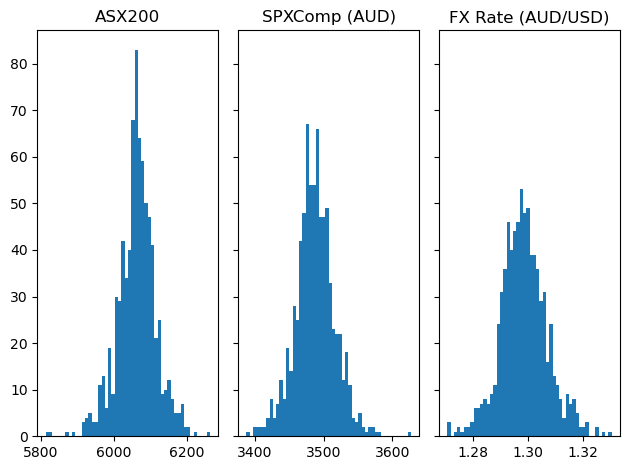

In [ ]:
# Histogram of simulated values
n_bins = 50

fig, sim_rf = plt.subplots(1, 3, sharey = True, tight_layout = True)

sim_rf[0].hist(sim_ASSD['ASSD200'], bins = n_bins)
sim_rf[1].hist(sim_BARC['BARCComp'], bins = n_bins)
sim_rf[2].hist(sim_FXrate['FXrate'], bins = n_bins)
# marginal histo
sim_rf[0].set_title('ASSD200')
sim_rf[1].set_title('BARCComp (AUD)')
sim_rf[2].set_title('FX Rate (AUD/USD)')

# VaR for Portfolio of Physical Assets

## Historical Simulation

Each entry in `sim_ASSD`, `sim_BARC`, and `sim_FXrate` represents a hypothetical scenario for the three risk factors. The corresponding hypothetical value of the portfolio of physical assets can be calculated by multiplying each simulated value of the risk factors by the number of units we currently hold of each instrument.

The histogram of the hypothetical values of the portfolio of physical assets is also shown below. We note that the distribution of the hypothetical values and, consequently, the corresponding portfolio P\&L, is not symmetric and has several outliers.

Text(0.5, 1.0, 'Simulated portfolio values')

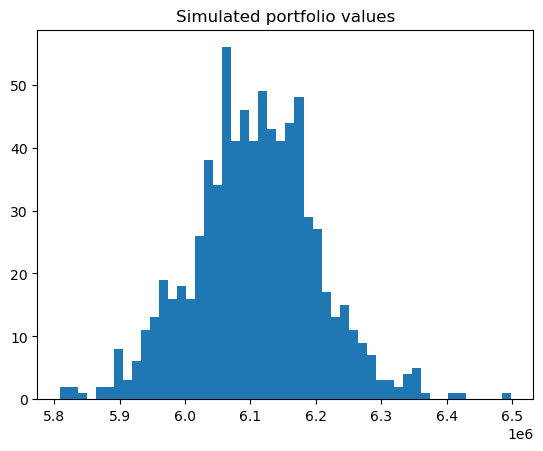

In [ ]:
# Hypothetical portfolio values
sim_V_portfolio = N_ASSD * sim_ASSD['ASSD200'] + N_BARC * sim_BARC['BARCComp'] + N_USD * sim_FXrate['FXrate']

# Visualize hypothetical portfolio values
fig, axs = plt.subplots()
axs.hist(sim_V_portfolio, bins = n_bins)
axs.set_title('Simulated portfolio values')
# not symmetric and outliers

To calculate the one-day VaR, we first calculate the P\&L corresponding to each hypothetical portfolio value. We do so by subtracting the current marked-to-market value of the portfolio from the hypothetical values.

In [ ]:
# Calculate simulated P&L values for the portfolio (physical assets only)
sim_delta_V = sim_V_portfolio - (V_ASSD + V_BARC + V_USD)

The distribution of the physical asset portfolio P\&L can also be visualized using the empirical CDF (ECDF) plot. The construction of the ECDF below assumes that all scenarios are equally likely to occur in the future.

The plot also shows a horizontal line at a $y$-value of 0.05. The $x$-coordinate of the intersection of the horizontal line and the EDCF is the (negative of the) VaR for the portfolio of physical assets. 

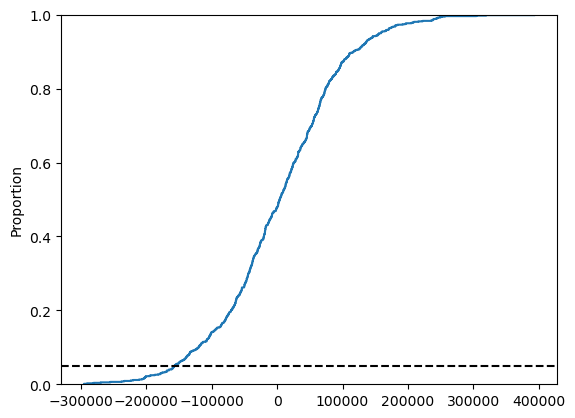

In [ ]:
# Display empirical CDF for the physical portfolio P&L
sim_delta_V_ecdf = sns.ecdfplot(data = sim_delta_V)

# Construct horizontal line showing the 5th percentile (corresponding to the 95% VaR)
conf_level = 0.95
sim_delta_V_ecdf.axhline(y = 1 - conf_level, xmin = 0, xmax = 1, linestyle = 'dashed', color = 'black')

To calculate the 95\% VaR, we sort the simulated P\&L values in increasing order then identify the value that is in the $(N_{\text{HS}}(1 - c))$-th position, where $N_{\text{HS}}$ is the number of hypothetical scenarios. This value is rounded up to the nearest integer using the function ``int()`` if the product is not an integer.

In [ ]:
# Calculate the required quantile for the 95% VaR
sim_delta_V_sort = sorted(sim_delta_V)
physical_asset_VaR = -sim_delta_V_sort[int(N_HS * (1-conf_level))]

physical_asset_VaR

157337.85541995894

In [ ]:
int(775*0.05)

38

## Weighted Historical Simulation

We deviate from the assumption that all hypothetical scenarios are equally likely to occur by introducing weights that decrease (exponentially/geometrically) the further in time the historical observation corresponding to the hypothetical value is from the current time of valuation/VaR calculation. The weight for the $j$th scenario, corresponding to the $j$th historically observed return in the time series, is given by

$$\lambda_j = \lambda^{N_{\text{HS}} - j}\frac{1 - \lambda}{1 - \lambda^{N_{\text{HS}}}},$$

where $\lambda\in[0,1]$ is a parameter governing the magnitude of the weights. The most recently observed historical return is given a weight of 

$$\lambda_{N_{\text{HS}}} = \frac{1 - \lambda}{1 - \lambda^{N_{\text{HS}}}}.$$

As specified in the instructions, we will use $\lambda = 0.98$.

In [ ]:
# Set weighting parameter lambda and weight storage variable
whs_lambda = 0.98
whs_weights = np.zeros(N_HS)

# Compute weights for each scenario
for j in range(0, N_HS):
    whs_weights[j] = (whs_lambda ** (N_HS - (j+1))) * (1 - whs_lambda) / (1 - whs_lambda ** N_HS)

In [ ]:
# Construct data frame containing simulated P&L for the portfolio with corresponding weights
sim_delta_V_whs = pd.DataFrame({'PnL' : sim_delta_V, 'Weight' : whs_weights})
sim_delta_V_whs.head()

,PnL,Weight
0,101990.278199,3.236031e-09
1,-133046.393188,3.302072e-09
2,72147.644284,3.369462e-09
3,66422.324241,3.438226e-09
4,23594.079491,3.508394e-09


To compute the 95\% VaR, we first sort the data frame above by the value of the P\&L, then produce another column containing the cumulative sum of the weights.

The ECDF below is generated using the weights as the probabilities associated to the hypothetical P\&L values.

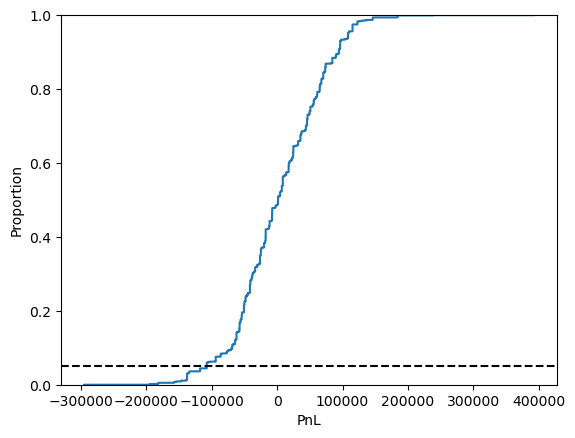

In [ ]:
# Sort data frame by PnL in increasing order
sim_delta_V_whs_sort = sim_delta_V_whs.sort_values(by = 'PnL')

# Calculate cumulative sum of the weights
cumsum_weights = sim_delta_V_whs_sort['Weight'].cumsum()
sim_delta_V_whs_sort['Weight_CumSum'] = cumsum_weights

# Display empirical CDF of weighted simulations
sim_delta_V_whs_ecdf = sns.ecdfplot(data = sim_delta_V_whs_sort, x = 'PnL', weights = 'Weight')
sim_delta_V_whs_ecdf.axhline(y = 1 - conf_level, xmin = 0, xmax = 1, linestyle = 'dashed', color = 'black')

The codes below show that the required 5th percentile is straddled by two values whose corresponding cumulative sums are close, but not equal, to 0.05.

In [ ]:
# Display entries with with cumulative sum less than 0.05
sim_delta_V_whs_sort[(sim_delta_V_whs_sort['Weight_CumSum'] < 1 - conf_level)]

,PnL,Weight,Weight_CumSum
303,-295509.276705,1.474048e-06,0.000001
370,-290470.838837,5.706432e-06,0.000007
229,-280690.407082,3.305532e-07,0.000008
5,-269920.061393,3.579994e-09,0.000008
93,-255135.699074,2.118301e-08,0.000008
...,...,...,...
67,-114111.337414,1.252753e-08,0.044163
532,-113441.935566,1.505707e-04,0.044314
412,-109822.519647,1.333121e-05,0.044327
518,-107912.814162,1.134764e-04,0.044441


In [ ]:
# Display entries with with cumulative sum greater than 0.05
sim_delta_V_whs_sort[(sim_delta_V_whs_sort['Weight_CumSum'] > 1 - conf_level)]

,PnL,Weight,Weight_CumSum
760,-107704.145555,1.507284e-02,0.059652
215,-107380.469297,2.491187e-07,0.059653
391,-106776.957912,8.722020e-06,0.059661
662,-105542.878224,2.081376e-03,0.061743
38,-105387.170789,6.973034e-09,0.061743
...,...,...,...
19,251536.320858,4.750258e-09,0.999941
188,256601.825334,1.443811e-07,0.999941
343,304838.941530,3.307263e-06,0.999944
61,319407.448187,1.109742e-08,0.999944


To determine the VaR, we may interpolate the P\&L value corresponding to a cumulative sum value of 0.05.

In [ ]:
# Interpolate the 95% VaR since the cumulative sums do not exactly match the required quantile
physical_asset_VaR_whs = -np.interp(x = 1 - conf_level, xp = sim_delta_V_whs_sort['Weight_CumSum'],
                                  fp = sim_delta_V_whs_sort['PnL'])

physical_asset_VaR_whs

107813.33824614665

Alternatively, we may invoke the formal definition of VaR, which is the smallest value of the P&L for which the cumulative sum is greater than 0.05.

*Recall:* $\text{VaR}_c = -\inf\{x\in\mathbb{R} : P(\Delta V \leq x) \geq 1-c\}$, with a negative sign preceding the infimum since this value is typically negative.

In [ ]:
# Alternative calculation of VaR
sim_delta_V_above = sim_delta_V_whs_sort[(sim_delta_V_whs_sort['Weight_CumSum'] >= 1 - conf_level)].reset_index()

physical_asset_VaR_whs_2 = -sim_delta_V_above.loc[0, 'PnL']
physical_asset_VaR_whs_2

107704.14555486664

# VaR for Call Option on ASSD 200

Historical simulation for more complex financial instruments, such as options, is conducted using a full valuation approach. For example, to calculate the VaR for the call option on the ASSD 200, we need to calculate the option price corresponding to each hypothetical value of the ASSD 200 price.

If a full valuation is too complex, one may resort to a local approximation (i.e. a delta or delta-gamma approximation with respect to appropriate risk factors).

Below, we show both the standard and weighted historical simulation method to calculate the 95\% VaR for each unit of the call option on the ASSD 200.

## Historical Simulation

In [ ]:
# Container for simulated call option prices
sim_op_ASSD = np.zeros(N_HS)

# Calculate call option prices based on scenarios of the ASSD 200
for j in range(0, N_HS):
    sim_ASSD_price = sim_ASSD.loc[j, 'ASSD200']
    sim_op_ASSD[j] = BSprice(sim_ASSD_price, strike_ASSD, mat_ASSD, r_ASSD, 0, vol_ASSD, 'call')

(array([ 1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  4.,  3.,  7.,
         3.,  4., 14., 10., 10., 16., 18., 33., 33., 40., 40., 48., 82.,
        70., 58., 57., 49., 43., 26., 24., 19., 10., 10., 10.,  7.,  5.,
         5.,  6.,  2.,  2.,  1.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([-1.20640277e+02, -1.15998620e+02, -1.11356963e+02, -1.06715307e+02,
        -1.02073650e+02, -9.74319937e+01, -9.27903372e+01, -8.81486806e+01,
        -8.35070240e+01, -7.88653675e+01, -7.42237109e+01, -6.95820543e+01,
        -6.49403978e+01, -6.02987412e+01, -5.56570847e+01, -5.10154281e+01,
        -4.63737715e+01, -4.17321150e+01, -3.70904584e+01, -3.24488019e+01,
        -2.78071453e+01, -2.31654887e+01, -1.85238322e+01, -1.38821756e+01,
        -9.24051905e+00, -4.59886249e+00,  4.27940762e-02,  4.68445064e+00,
         9.32610720e+00,  1.39677638e+01,  1.86094203e+01,  2.32510769e+01,
         2.78927334e+01,  3.25343900e+01,  3.71760466e+01,  4.18177031e+01,
         4.64593597e+01,  5.1101

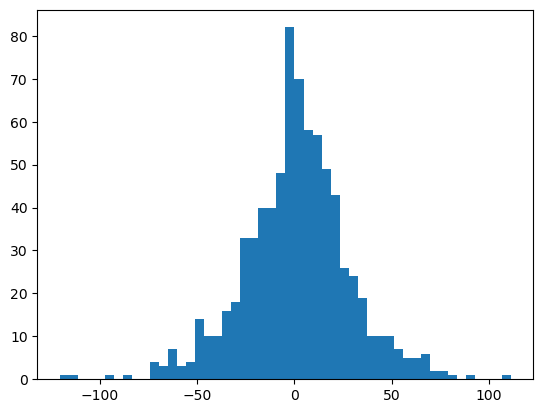

In [ ]:
# Calculate simulated P&L for the call option (per unit call option)
sim_delta_op_ASSD = sim_op_ASSD - price_ASSD

# Visualize using histogram
fig, sim_op_ASSD_hist = plt.subplots()
sim_op_ASSD_hist.hist(sim_delta_op_ASSD, bins = n_bins)

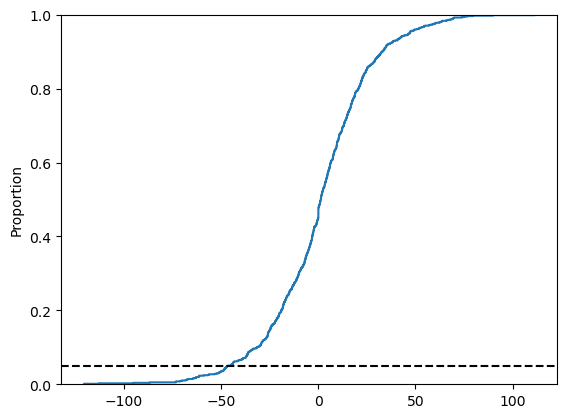

In [ ]:
# Visualize using empirical CDF
# per option
sim_delta_op_ASSD_ecdf = sns.ecdfplot(data = sim_delta_op_ASSD)
sim_delta_op_ASSD_ecdf.axhline(y = 1 - conf_level, xmin = 0, xmax = 1, linestyle = 'dashed', color = 'black')

In [ ]:
# Calculate the required quantile for the 95% VaR
sim_delta_op_ASSD_sort = sorted(sim_delta_op_ASSD)
op_ASSD_VaR = -sim_delta_op_ASSD_sort[int(N_HS * (1-conf_level))]

op_ASSD_VaR

46.8534186284237

## Weighted Historical Simulation

In [ ]:
# Combine into one data frame the PnL and the corresponding weights
sim_delta_op_ASSD_whs = pd.DataFrame({'PnL' : sim_delta_op_ASSD, 'Weight' : whs_weights})

# Sort the data frame by the PnL
sim_delta_op_ASSD_whs_sort = sim_delta_op_ASSD_whs.sort_values(by = 'PnL')

# Calculate the cumulative sum of weights
cumsum_weights = sim_delta_op_ASSD_whs_sort['Weight'].cumsum()
sim_delta_op_ASSD_whs_sort['Weight_CumSum'] = cumsum_weights

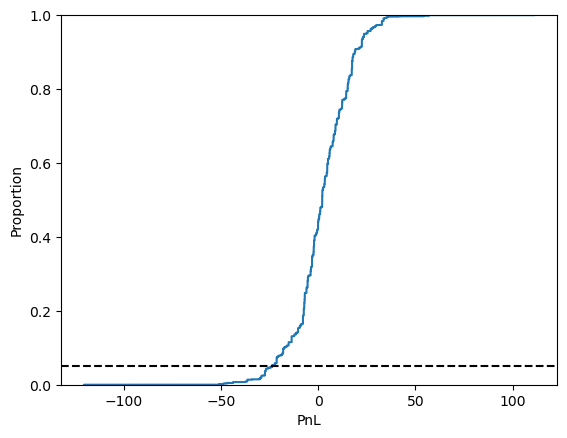

In [ ]:
# Display empirical CDF of weighted simulations
sim_delta_op_ASSD_whs_ecdf = sns.ecdfplot(data = sim_delta_op_ASSD_whs_sort, x = 'PnL', weights = 'Weight')
sim_delta_op_ASSD_whs_ecdf.axhline(y = 1 - conf_level, xmin = 0, xmax = 1, linestyle = 'dashed', color = 'black')

In [ ]:
# Interpolate the 95% VaR since the cumulative sums do not exactly match the required quantile
op_ASSD_VaR_whs = -np.interp(x = 0.05, xp = sim_delta_op_ASSD_whs_sort['Weight_CumSum'],
                                  fp = sim_delta_op_ASSD_whs_sort['PnL'])

op_ASSD_VaR_whs

23.785032217848705